# Wasserstein GAN
This note is a section by section summary of the [paper](https://arxiv.org/abs/1701.07875)  based on personal understanding. Some personal remarks appear at the end of the note.

## 1. Introduction

we often define parametric family of densities $P_\theta$ to learn probability distribution. 



## 2. Related work

Most work on deep generative models focused on models that provided a parametric specification of a probability distributions. But GAN does not assume any distribution



## 3. Adversarial nets

$D$ and $G$ play the following two-player *minimax* game $\min_\theta \max_\phi V(D_\phi,G_\theta)$ where

$$
V(D_\phi,G_\theta) = \mathbb{E}_{x\sim p_{data}} [\log D_\phi(x)] + \mathbb{E}_{z\sim p_z} [\log (1-D_\phi(G_\theta(z)))]
$$

Optimizing $D$ to completion in the inner loop of training is computationally prohibitive, and on finite datasets would result in overfitting. Instead, we alternate between k steps of optimizing $D$ and one step of optimizing $G$. This results in $D$ being maintained near its optimal solution, so long as $G$ changes slowly enough.

---
#### $\,$ Algorithm 1  
$\quad$**for** epcohs **do**  
$\quad\quad$  **for** $k$ steps **do**  
$\quad\quad\quad$  $m$ sample of $z\sim p_z$  
$\quad\quad\quad$  $m$ sample of data $x\in p_{data}$  
$\quad\quad\quad$  Update $D$ by ascending its stochastic gradient:  
$$\nabla_\theta \frac{1}{m} \sum_i^m \log D_\phi(x_i) + \log (1-D_\phi(G_\theta(z_i)))
$$
$\quad\quad$  **end for**  
$\quad\quad$  $m$ sample of $z\sim p_z$  
$\quad\quad$  Update $G$ by descending its stochastic gradient:  
$$
\nabla_\phi \frac{1}{m} \sum_i^m  \log (1-D_\phi(G_\theta(z_i)))
$$
$\quad$**end for**  
---



## 4. Theoretical results

will Algorithm 1. converge to good estimator of $p_{data}$?

#### 4.1. Global Optimzality of $p_g=p_{data}$

**Proposition 1.** For $G$ fixed (i.e. $\theta$ fixed), the optimal $D$ is
$$
D^*_\theta(x) = \frac{p_{data}(x)}{p_{data}(x)+p_{g,\theta}(x)}
$$
(note: $D^*_\theta(x)$ now depends on $\theta$ not $\phi$)


**proof:** 
$$
\begin{eqnarray}
V(D_\phi,G_\theta) &=& \mathbb{E}_{x\sim p_{data}} [\log D_\phi(x)] + \mathbb{E}_{z\sim p_z} [\log (1-D_\phi(G_\theta(z)))] \\
                   &=& \int_x p_{data}(x) \log D_\phi(x) dx +  \int_z p_z (z) \log (1-D_\phi(G_\theta(z))) dz\\
                   &=& \int_x \left[ p_{data}(x) \log D_\phi(x) +  p_{g,\theta} (x) \log (1-D_\phi(x)) \right] dx
\end{eqnarray}
$$

For any $(a,b)\in \mathbb{R} \backslash \{0,0\}$, the function $f(x) = a \log(x) + b \log(1-x)$ is maximum in $[0,1]$ at $\frac{a}{a+b}$. 

**Define** the *max* part of *minmax* game as
$$
\begin{eqnarray}
C(\theta) &=& \max_\phi V(D_\phi,G_\theta) \\
          &=& \mathbb{E}_{x\sim p_{data}} [\log D^*_\theta(x)] + \mathbb{E}_{x\sim p_g} [\log (1-D^*_\theta(x))]
\end{eqnarray}
$$

**Theorem 1.** The global minimum of $C(\theta)$ is achieved *if and only if* $p_{g,\theta} = p_{data}$ at which $C(\theta)=-\log4$

**proof:** $C(\theta)$ can be re-written by
$$
C(\theta) = -\log 4 + KL\left(p_{data}| \frac{p_{data}+p_{g,\theta}}{2}\right)  + KL\left(p_{g,\theta}| \frac{p_{data}+p_{g,\theta}}{2}\right) 
$$

#### 4.2 Convergence of Algorithm 1.

**Proposition 2.** If $G_\theta$ and $D_\phi$ have enough capacity, the discriminator is allowed to reach its optimum given $G_\theta$, then $p_g \rightarrow p_{data}$

In practice, adversarial nets represent a limited family of $p_g$, so the proofs do not apply. However, the excellent performance of NN in practice suggests that they are a reasonable model.

Following plots illustrates the convergence given optimal $D^*$ (plots are from the [paper](https://arxiv.org/abs/1406.2661)).

<img src="GAN_trainG_withOptimumD.png" width="600"/>

*blue dashed*: distribution of $D$, $\,$ *green solid*: distribution of $p_g$, $\,$ *black dotted*: distribution of $p_{data}$  
(a) before $D$ is optimum. $\,$ (b) $D=D^*$. $\,$ (c) and (d) $p_g$ is converging to $p_{data}$.



## 5. Experiments

- $G_\theta$: ReLu, Sigmoid  
- $D_\phi$: Dropout, Maxout 
    - Maxout: max$\left(w_1^T x + b_1, \, w_2^T x + b_2\right)$. 
        - advantage : gradient does not saturate
        - disadvantage: need two neurons

The mean log-likelyhood on samples from test data (MNIST) performed best compared other genertive models (see the paper for details). The likelihood of $p_g$ is estimated by fitting Gaussian Parzen window (a kernel density estimation method) to the samples generated by $G$.

## 6. Advantages and disadvantages



- Advantages
    - Generator is not directly exposed to data $\rightarrow$ parameters does not memorize inputs ($\rightarrow$ avoid overfit? )
    - Can represent sharp or [degenerate](https://en.wikipedia.org/wiki/Degenerate_distribution) disribution ($\rightarrow$ better quality? )
- Disadvantages
    - No explicit representation of $p_g$
    - Training can be tricky: $G$ v.s. $D$


# Remark
Early in learning, when $G$ is poor, $D$ can reject samples with high confidence. Rather than training G to minimize $\log(1 - D(G(z)))$ we can train $G$ to maximize $\log D(G(z))$. This objective function results in the
same fixed point of the dynamics of $G$ and $D$ but provides much stronger gradients early in learning. See the plot below

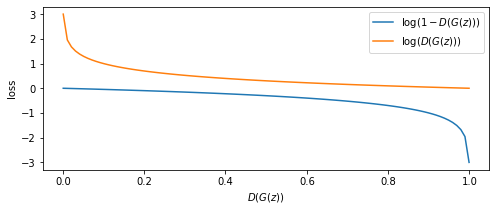

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def loss_minimax(x):
    return np.log10(1-x)

def loss_non_saturate(x):
    return -np.log10(x)

X = np.linspace(0.001,0.999,100)
plt.figure(figsize=(8,3))

plt.plot(X, loss_minimax(X),     label=r'$\log(1-D(G(z)))$')
plt.plot(X, loss_non_saturate(X),label=r'$\log(D(G(z)))$')

plt.xlabel(r'$D(G(z))$')
plt.ylabel('loss')
plt.legend();